c:\unibuc mafia\rl\maze-rl\rl-env\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Episode 200/2000 | eps=0.819 | avg_reward(last200)=0.380 | success_rate(last200)=61.50%
Episode 400/2000 | eps=0.670 | avg_reward(last200)=0.779 | success_rate(last200)=99.50%
Episode 600/2000 | eps=0.549 | avg_reward(last200)=0.880 | success_rate(last200)=100.00%
Episode 800/2000 | eps=0.449 | avg_reward(last200)=0.902 | success_rate(last200)=100.00%
Episode 1000/2000 | eps=0.368 | avg_reward(last200)=0.922 | success_rate(last200)=100.00%
Episode 1200/2000 | eps=0.301 | avg_reward(last200)=0.935 | success_rate(last200)=100.00%
Episode 1400/2000 | eps=0.246 | avg_reward(last200)=0.939 | success_rate(last200)=100.00%
Episode 1600/2000 | eps=0.202 | avg_reward(last200)=0.944 | success_rate(last200)=100.00%
Episode 1800/2000 | eps=0.165 | avg_reward(last200)=0.946 | success_rate(last200)=100.00%
Episode 2000/2000 | eps=0.135 | avg_reward(last200)=0.948 | success_rate(last200)=100.00%


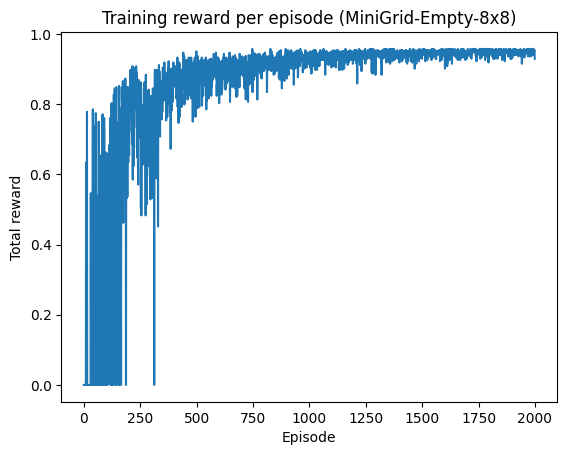

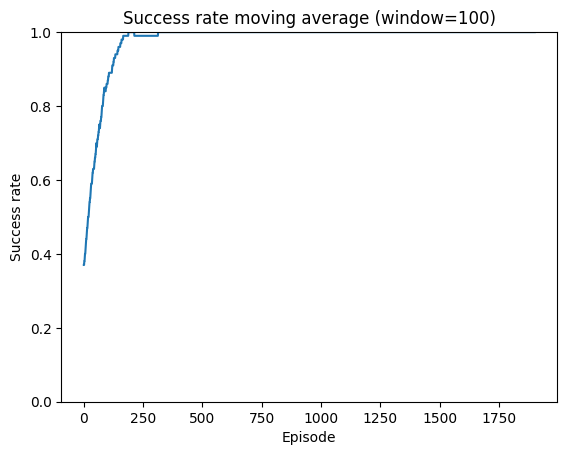

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import minigrid

# ---------------------------
# Helpers: rendering
# ---------------------------
def show(frame):
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(frame)
    plt.show()

# ---------------------------
# 1) Environment (TRAIN: no rendering)
# ---------------------------
env = gym.make("MiniGrid-Empty-8x8-v0")
n_actions = env.action_space.n

# MiniGrid action meanings (for reference)
# 0 = left, 1 = right, 2 = forward, 3 = pickup, 4 = drop, 5 = toggle, 6 = done

# ---------------------------
# 2) State encoding (simple & correct for Empty)
# ---------------------------
def get_state(env):
    u = env.unwrapped
    ax, ay = u.agent_pos
    ad = int(u.agent_dir)
    return (ax, ay, ad)

# ---------------------------
# 3) Q-learning components
# ---------------------------
Q = defaultdict(lambda: np.zeros(n_actions, dtype=np.float32))

def epsilon_greedy(state, eps):
    if np.random.rand() < eps:
        return env.action_space.sample()
    return int(np.argmax(Q[state]))

def train_q_learning(
    episodes=2000,
    max_steps=200,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.999,
):
    rewards = []
    success = []
    eps = eps_start

    for ep in range(episodes):
        obs, info = env.reset()
        s = get_state(env)

        total_r = 0.0
        last_r = 0.0

        for t in range(max_steps):
            a = epsilon_greedy(s, eps)

            obs2, r, terminated, truncated, info = env.step(a)
            s2 = get_state(env)

            done = terminated or truncated

            # Standard Q-learning update
            td_target = float(r) + (0.0 if done else gamma * float(np.max(Q[s2])))
            Q[s][a] += alpha * (td_target - Q[s][a])

            s = s2
            total_r += float(r)
            last_r = float(r)

            if done:
                break

        eps = max(eps_end, eps * eps_decay)

        rewards.append(total_r)
        # In MiniGrid, reaching the goal typically yields positive reward
        success.append(1 if last_r > 0 else 0)

        if (ep + 1) % 200 == 0:
            print(
                f"Episode {ep+1}/{episodes} | eps={eps:.3f} | "
                f"avg_reward(last200)={np.mean(rewards[-200:]):.3f} | "
                f"success_rate(last200)={np.mean(success[-200:]):.2%}"
            )

    return rewards, success

# ---------------------------
# 4) Greedy evaluation (optionally render)
# ---------------------------
def run_greedy_episode(env_eval, max_steps=200, render=False):
    obs, info = env_eval.reset()
    s = get_state(env_eval)

    total_r = 0.0
    last_r = 0.0

    for t in range(max_steps):
        a = int(np.argmax(Q[s]))
        obs, r, terminated, truncated, info = env_eval.step(a)
        s = get_state(env_eval)

        total_r += float(r)
        last_r = float(r)

        if render:
            show(env_eval.render())

        if terminated or truncated:
            break

    return total_r, last_r

# ---------------------------
# 5) Train
# ---------------------------
rewards, success = train_q_learning(
    episodes=2000,
    max_steps=200,
    alpha=0.10,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.999,
)

# Plot learning curves (optional)
plt.figure()
plt.plot(rewards)
plt.title("Training reward per episode (MiniGrid-Empty-8x8)")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()

plt.figure()
# moving average success rate
window = 100
if len(success) >= window:
    ma = np.convolve(success, np.ones(window)/window, mode="valid")
    plt.plot(ma)
    plt.title(f"Success rate moving average (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Success rate")
    plt.ylim(0, 1)
    plt.show()

# ---------------------------
# 6) Demo with rendering (EVAL env with rgb_array)
# ---------------------------
# env_eval = gym.make("MiniGrid-Empty-8x8-v0", render_mode="rgb_array")

# print("\nGreedy evaluation runs:")
# for i in range(3):
#     total_r, last_r = run_greedy_episode(env_eval, max_steps=200, render=False)
#     print(f"  eval {i+1}: total_reward={total_r:.3f}, final_step_reward={last_r:.3f}")

# print("\nRendering one greedy run:")
# total_r, last_r = run_greedy_episode(env_eval, max_steps=200, render=True)
# print(f"Rendered run: total_reward={total_r:.3f}, final_step_reward={last_r:.3f}")
